## **Necessary Libraries**

In [ ]:
import os
import tarfile
import pandas as pd
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from matplotlib_venn import venn2


import glob
import tarfile
import nltk
import plotly.express as px
import plotly.graph_objects as go
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

In [ ]:
!git clone https://github.com/nltk/nltk.git
!pip install ./nltk

Cloning into 'nltk'...
remote: Enumerating objects: 81463, done.
remote: Counting objects: 100% (190/190), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 81463 (delta 154), reused 124 (delta 124), pack-reused 81273 (from 3)
Receiving objects: 100% (81463/81463), 111.71 MiB | 18.42 MiB/s, done.
Resolving deltas: 100% (57773/57773), done.
Processing ./nltk
  Preparing metadata (setup.py) ... done
  Created wheel for nltk: filename=nltk-3.9.2-py3-none-any.whl size=1510571 sha256=b7f30d36774fb78b87be4637fbbaa099bc96caafd667cc3f7dff1fa295256fdd
  Stored in directory: /tmp/pip-ephem-wheel-cache-n911a330/wheels/e3/b5/db/7ea49afe8ccf25126f3d4583bafb3f2b0d21cc99b190823d59
Successfully built nltk
  Attempting uninstall: nltk
    Found existing installation: nltk 3.9.1
    Uninstalling nltk-3.9.1:
      Successfully uninstalled nltk-3.9.1


In [ ]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Initialize NLP tools
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## **Loading Dataset**

In [ ]:
zip_file_path = "/content/20news-bydate.tar.gz"
extract_path = "/content/20_news"

if not os.path.exists(extract_path):  # Check if already extracted
    with tarfile.open(zip_file_path, "r:gz") as tar:
        tar.extractall(path=extract_path)

In [ ]:
# Paths to training and test sets
train_path = os.path.join(extract_path, "20news-bydate-train")
test_path = os.path.join(extract_path, "20news-bydate-test")

## **Descriptive Analysis (Before Preprocessing)**




In [ ]:
# Get the list of categories (folders) in each set
train_categories = sorted(os.listdir(train_path))
test_categories = sorted(os.listdir(test_path))

In [ ]:
# Count the number of documents per category
train_counts = {category: len(os.listdir(os.path.join(train_path, category))) for category in train_categories}
test_counts = {category: len(os.listdir(os.path.join(test_path, category))) for category in test_categories}


### **1.Dataset Overview**

In [ ]:
# Function to load dataset: Extract texts and labels
def load_data(base_path, categories):
    texts, labels = [], []
    for category in categories:
        category_path = os.path.join(base_path, category)
        for filename in os.listdir(category_path):
            file_path = os.path.join(category_path, filename)
            with open(file_path, "r", encoding="latin1") as file:
                texts.append(file.read())  # Read file content
                labels.append(category)  # Label is the category name
    return texts, labels

# Load training and test data
train_texts, train_labels = load_data(train_path, train_categories)
test_texts, test_labels = load_data(test_path, test_categories)

# Count the number of documents per category (validation check)
train_counts = {category: train_labels.count(category) for category in train_categories}
test_counts = {category: test_labels.count(category) for category in test_categories}

In [ ]:
# Dataset Overview
num_train_docs = len(train_texts)
num_test_docs = len(test_texts)
total_docs = num_train_docs + num_test_docs
num_categories = len(set(train_labels))

print(f"Total documents: {total_docs}")
print(f"Training set: {num_train_docs} documents")
print(f"Test set: {num_test_docs} documents")
print(f"Number of categories: {num_categories}")


Total documents: 18846
Training set: 11314 documents
Test set: 7532 documents
Number of categories: 20


In [ ]:
# Word Count Analysis
def get_word_counts(texts):
    return [len(text.split()) for text in texts]

train_word_counts = get_word_counts(train_texts)
test_word_counts = get_word_counts(test_texts)

print(f"Average words per document (Train): {sum(train_word_counts) / len(train_word_counts):.2f}")
print(f"Average words per document (Test): {sum(test_word_counts) / len(test_word_counts):.2f}")
print(f"Longest document (words): {max(train_word_counts)}")
print(f"Shortest document (words): {min(train_word_counts)}")

Average words per document (Train): 287.47
Average words per document (Test): 277.93
Longest document (words): 11821
Shortest document (words): 14


In [ ]:
# Vocabulary Size
all_words = " ".join(train_texts).split()
unique_words = set(all_words)
print(f"Total vocabulary size: {len(unique_words)}")

Total vocabulary size: 280308


### **2. Overview of Training Set**

1. Category Distribution

In [ ]:
categories = os.listdir(train_path)
num_categories = len(categories)

# Count the number of files
category_counts = {category: len(os.listdir(os.path.join(train_path, category))) for category in categories}

# Convert to DataFrame for visualization
category_df = pd.DataFrame.from_dict(category_counts, orient='index', columns=['File Count'])
category_df = category_df.sort_values(by='File Count', ascending=False)

In [ ]:
# Display document count per category
for category, count in category_counts.items():
    print(f"{category}: {count} documents")

sci.electronics: 591 documents
rec.sport.hockey: 600 documents
talk.religion.misc: 377 documents
rec.autos: 594 documents
misc.forsale: 585 documents
comp.sys.mac.hardware: 578 documents
soc.religion.christian: 599 documents
rec.motorcycles: 598 documents
rec.sport.baseball: 597 documents
alt.atheism: 480 documents
comp.os.ms-windows.misc: 591 documents
sci.crypt: 595 documents
comp.graphics: 584 documents
talk.politics.guns: 546 documents
sci.space: 593 documents
talk.politics.mideast: 564 documents
comp.windows.x: 593 documents
talk.politics.misc: 465 documents
comp.sys.ibm.pc.hardware: 590 documents
sci.med: 594 documents


<Figure size 1200x600 with 0 Axes>

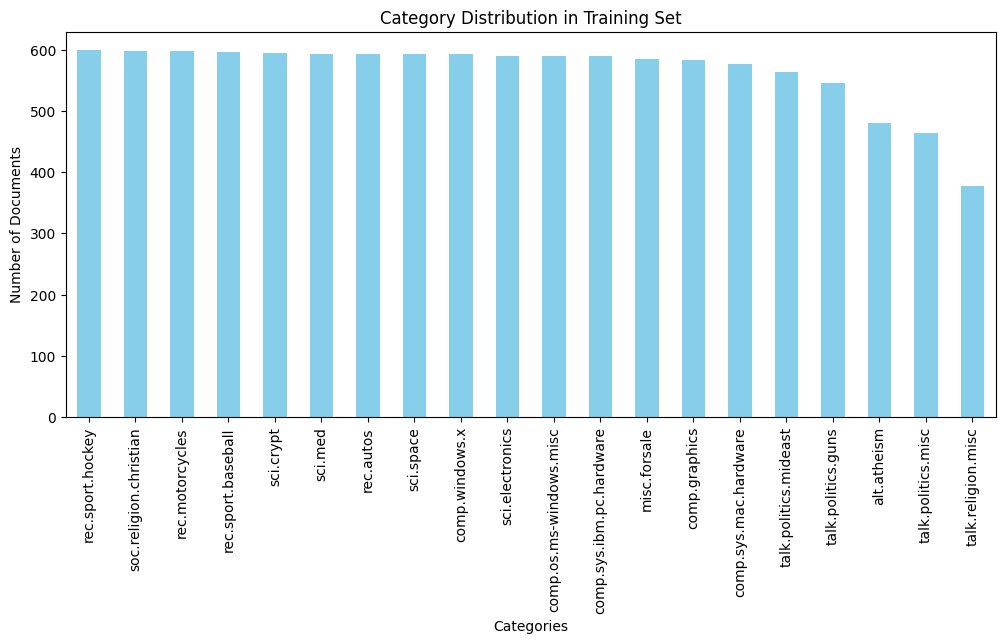

In [ ]:
# Plot category distribution
plt.figure(figsize=(12, 6))
category_df.plot(kind="bar", legend=False, color="skyblue", figsize=(12,5))
plt.xlabel("Categories")
plt.ylabel("Number of Documents")
plt.title("Category Distribution in Training Set")
plt.xticks(rotation=90)
plt.show()

2. Text Length Distribution

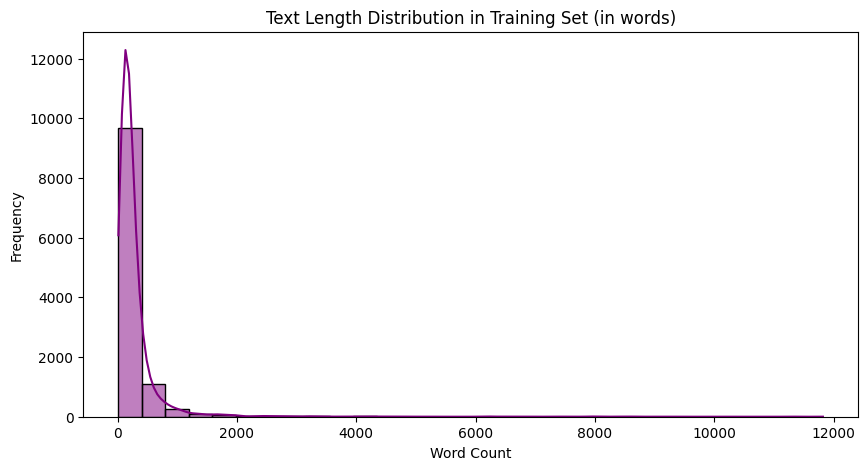

In [ ]:
# Text Length Distribution
# Convert the 'text' column to string type before applying the split function

import pandas as pd

# Create DataFrame from extracted text and labels
train_df = pd.DataFrame({"text": train_texts, "label": train_labels})


train_df["word_count"] = train_df["text"].astype(str).apply(lambda x: len(x.split()))


plt.figure(figsize=(10, 5))
sns.histplot(train_df["word_count"], bins=30, kde=True, color="purple")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.title("Text Length Distribution in Training Set (in words)")
plt.show()

3. Most Common Words

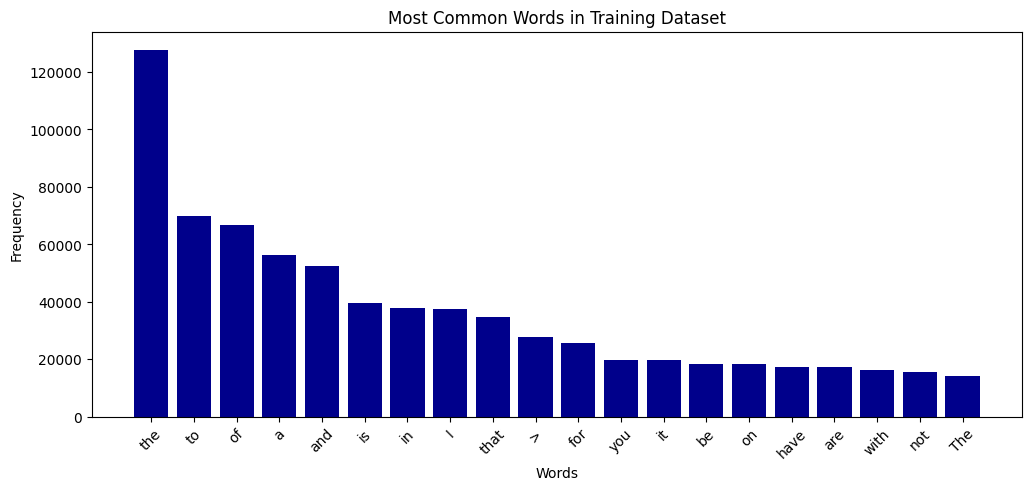

In [ ]:
# 3. Most Common Words
all_words = " ".join(train_df["text"].astype(str)).split() # Convert 'text' column to string
word_freq = Counter(all_words)
common_words = word_freq.most_common(20)

plt.figure(figsize=(12, 5))
plt.bar(*zip(*common_words), color="darkblue")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Most Common Words in Training Dataset")
plt.xticks(rotation=45)
plt.show()

4. Word Cloud

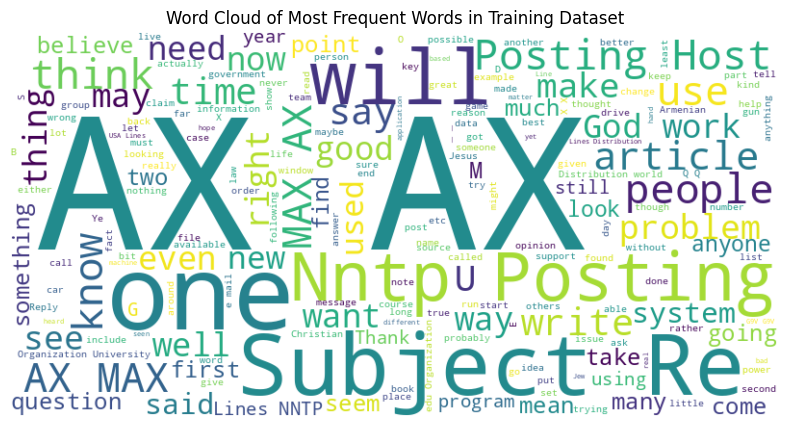

In [ ]:
#Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(all_words))


plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Most Frequent Words in Training Dataset")
plt.show()

### **3. Overview of Test Set**

1. Category Distribution

In [ ]:
categories = os.listdir(test_path)
num_categories = len(categories)

# Count the number of files per category
category_counts = {category: len(os.listdir(os.path.join(test_path, category))) for category in categories}

# Convert to DataFrame for visualization
category_df = pd.DataFrame.from_dict(category_counts, orient='index', columns=['File Count'])
category_df = category_df.sort_values(by='File Count', ascending=False)

In [ ]:
# Display document count per category
for category, count in category_counts.items():
    print(f"{category}: {count} documents")

sci.electronics: 393 documents
rec.sport.hockey: 399 documents
talk.religion.misc: 251 documents
rec.autos: 396 documents
misc.forsale: 390 documents
comp.sys.mac.hardware: 385 documents
soc.religion.christian: 398 documents
rec.motorcycles: 398 documents
rec.sport.baseball: 397 documents
alt.atheism: 319 documents
comp.os.ms-windows.misc: 394 documents
sci.crypt: 396 documents
comp.graphics: 389 documents
talk.politics.guns: 364 documents
sci.space: 394 documents
talk.politics.mideast: 376 documents
comp.windows.x: 395 documents
talk.politics.misc: 310 documents
comp.sys.ibm.pc.hardware: 392 documents
sci.med: 396 documents


<Figure size 1200x600 with 0 Axes>

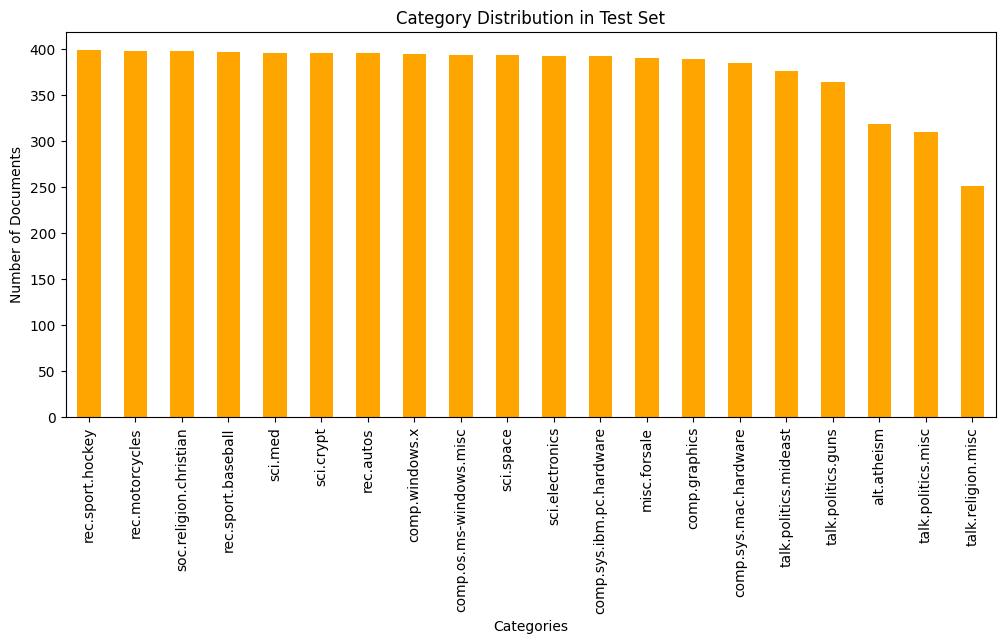

In [ ]:
# Plot category distribution
plt.figure(figsize=(12, 6))
category_df.plot(kind="bar", legend=False, color="orange", figsize=(12,5))
plt.xlabel("Categories")
plt.ylabel("Number of Documents")
plt.title("Category Distribution in Test Set")
plt.xticks(rotation=90)
plt.show()

2. Text Length Distribution

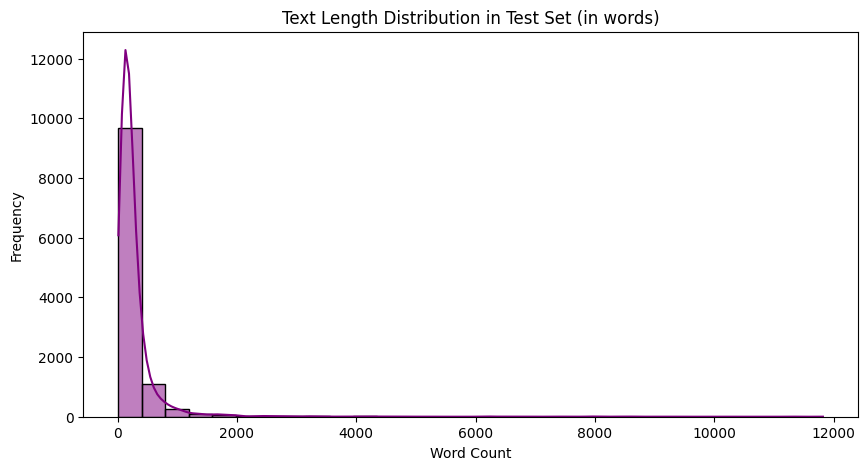

In [ ]:
# Text Length Distribution
# Convert the 'text' column to string type before applying the split function

import pandas as pd

# Create DataFrame from extracted text and labels
test_df = pd.DataFrame({"text": test_texts, "label": test_labels})


test_df["word_count"] = test_df["text"].astype(str).apply(lambda x: len(x.split()))


plt.figure(figsize=(10, 5))
sns.histplot(train_df["word_count"], bins=30, kde=True, color="purple")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.title("Text Length Distribution in Test Set (in words)")
plt.show()

3. Most Common Words

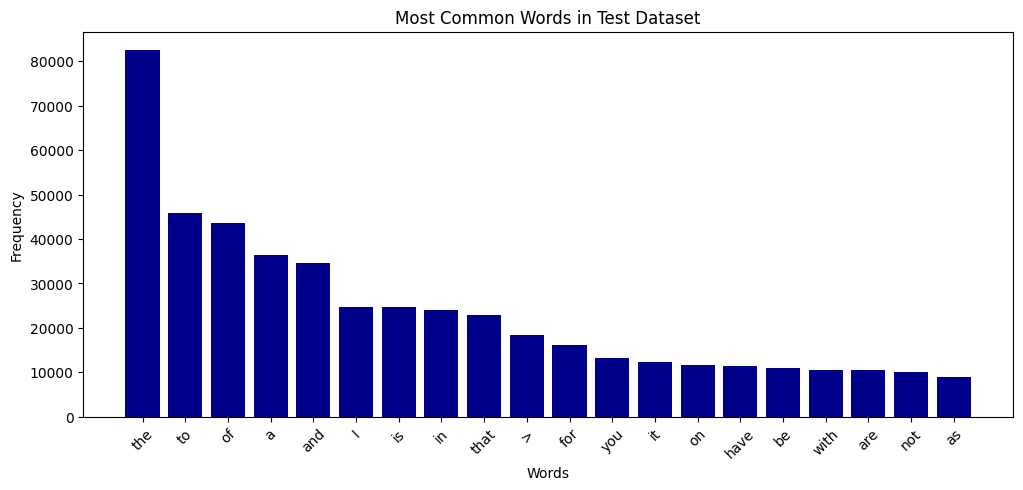

In [ ]:
# Most Common Words
all_words = " ".join(test_df["text"].astype(str)).split() # Convert 'text' column to string
word_freq = Counter(all_words)
common_words = word_freq.most_common(20)

plt.figure(figsize=(12, 5))
plt.bar(*zip(*common_words), color="darkblue")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Most Common Words in Test Dataset")
plt.xticks(rotation=45)
plt.show()

4. Word Cloud

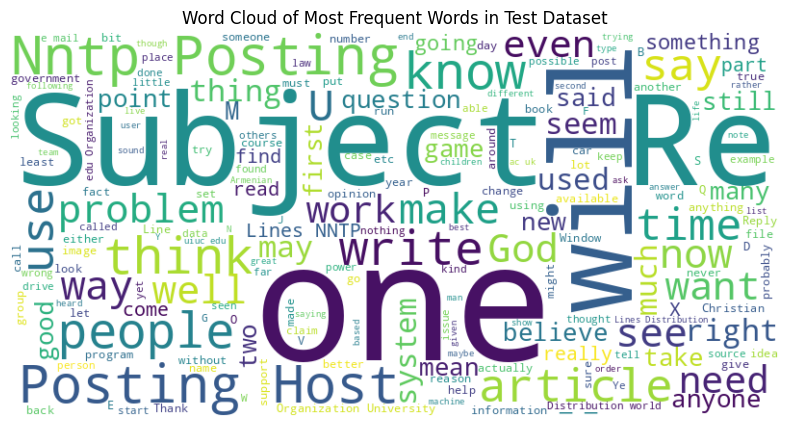

In [ ]:
#Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(all_words))


plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Most Frequent Words in Test Dataset")
plt.show()

### **4. Comparison of Train vs Test Document Count**

In [ ]:
# Count the number of files in each category for train and test sets
train_counts = {category: len(os.listdir(os.path.join(train_path, category))) for category in os.listdir(train_path)}
test_counts = {category: len(os.listdir(os.path.join(test_path, category))) for category in os.listdir(test_path)}

# Convert to DataFrame
compare_df = pd.DataFrame({"Train Count": train_counts, "Test Count": test_counts})

In [ ]:
# Display the document count comparison
print(compare_df)

                          Train Count  Test Count
sci.electronics                   591         393
rec.sport.hockey                  600         399
talk.religion.misc                377         251
rec.autos                         594         396
misc.forsale                      585         390
comp.sys.mac.hardware             578         385
soc.religion.christian            599         398
rec.motorcycles                   598         398
rec.sport.baseball                597         397
alt.atheism                       480         319
comp.os.ms-windows.misc           591         394
sci.crypt                         595         396
comp.graphics                     584         389
talk.politics.guns                546         364
sci.space                         593         394
talk.politics.mideast             564         376
comp.windows.x                    593         395
talk.politics.misc                465         310
comp.sys.ibm.pc.hardware          590         392


<Figure size 1200x600 with 0 Axes>

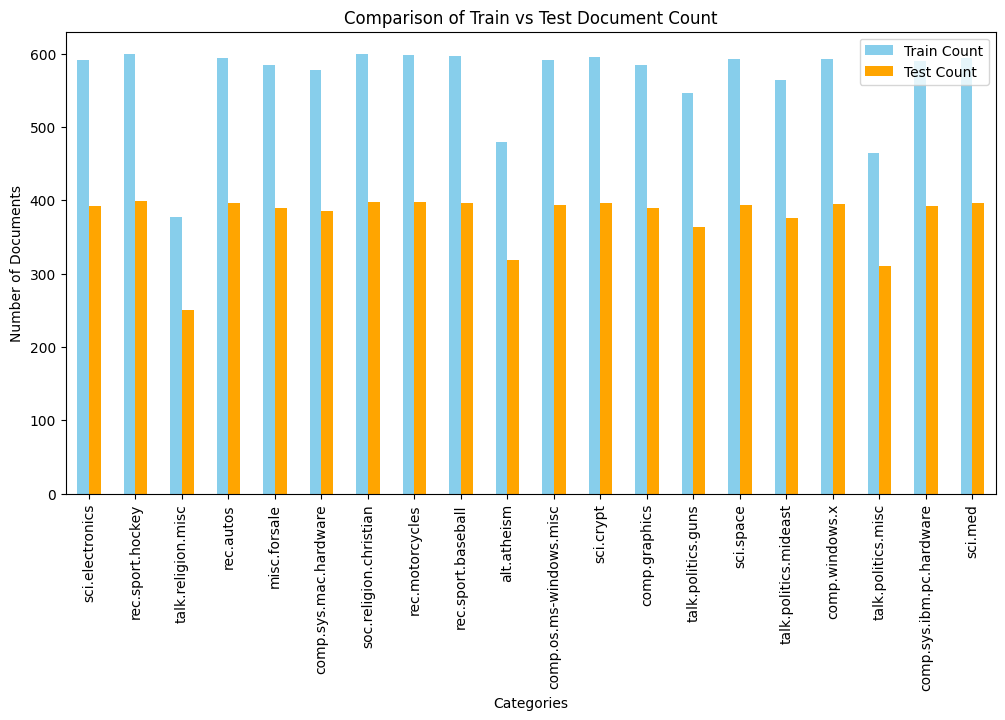

In [ ]:
# Plot comparison
plt.figure(figsize=(12, 6))
compare_df.plot(kind="bar", figsize=(12,6), color=["skyblue", "orange"])
plt.xlabel("Categories")
plt.ylabel("Number of Documents")
plt.title("Comparison of Train vs Test Document Count")
plt.xticks(rotation=90)
plt.legend(["Train Count", "Test Count"])
plt.show()

## **Preprocessing**

In [ ]:
# Initialize lemmatizer and stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [ ]:
# Advanced Text Cleaning
def clean_text(text):
    """Removes metadata, special characters, stopwords, and lemmatizes"""
    text = re.sub(r'^(From:|Subject:|Article-I.D.:|Reply-To:|Distribution:|Organization:|Lines:|Expires:).*$', '', text, flags=re.MULTILINE)
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip().lower()
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return " ".join(words)

In [ ]:
# Load dataset function
def load_dataset(dataset_path):
    """Loads all text files from dataset and returns a DataFrame."""
    data = []
    categories = sorted(os.listdir(dataset_path))

    for category in categories:
        category_path = os.path.join(dataset_path, category)
        files = glob.glob(os.path.join(category_path, "*"))

        for file_path in files:
            with open(file_path, "r", encoding="latin1") as f:
                text = f.read()
                cleaned_text = clean_text(text)
                data.append((cleaned_text, category))

    return pd.DataFrame(data, columns=["text", "category"])


In [ ]:
# Load train & test sets
df_train = load_dataset(train_path)
df_test = load_dataset(test_path)

# Save processed dataset
df_train.to_csv("/content/processed_train.csv", index=False)
df_test.to_csv("/content/processed_test.csv", index=False)

# Check dataset size
print("Training Set:", df_train.shape)
print("Testing Set:", df_test.shape)

Training Set: (11314, 2)
Testing Set: (7532, 2)


## **Descriptive Analysis (After Preprocessing)**

In [ ]:
# Basic statistics
num_categories = df_train["category"].nunique()
num_docs_train = df_train.shape[0]
num_docs_test = df_test.shape[0]

# Document count per category
category_counts = df_train["category"].value_counts()

# Average text length per document
df_train["text_length"] = df_train["text"].apply(len)
avg_text_length = df_train["text_length"].mean()

# Unique words
all_words = " ".join(df_train["text"]).split()
unique_words = len(set(all_words))

# Display statistics
dataset_stats = {
    "Total Categories": num_categories,
    "Total Training Documents": num_docs_train,
    "Total Testing Documents": num_docs_test,
    "Average Text Length": avg_text_length,
    "Unique Words": unique_words
}

for key, value in dataset_stats.items():
    print(f"{key}: {value}")

Total Categories: 20
Total Training Documents: 11314
Total Testing Documents: 7532
Average Text Length: 1043.176153438218
Unique Words: 106426


In [ ]:
# Print sample before and after cleaning
sample_text = train_texts[0]  # Pick the first document for validation
print("Before Preprocessing:", sample_text[:500])  # Show first 500 chars

cleaned_sample_text = clean_text(sample_text)
print("After Preprocessing:", cleaned_sample_text[:500])  # Show first 500 chars


Before Preprocessing: From: kmr4@po.CWRU.edu (Keith M. Ryan)
Subject: Re: A visit from the Jehovah's Witnesses
Organization: Case Western Reserve University
Lines: 48
NNTP-Posting-Host: b64635.student.cwru.edu

In article <SUOPANKI.93Apr6024902@stekt6.oulu.fi> suopanki@stekt6.oulu.fi (Heikki T. Suopanki) writes:
>:> God is eternal.    [A = B]
>:> Jesus is God.      [C = A]
>:> Therefore, Jesus is eternal.  [C = B]
>
>:> This works both logically and mathematically.  God is of the set of
>:> things which are eternal. 
After Preprocessing: nntppostinghost bstudentcwruedu article suopankiaprstektoulufi suopankistektoulufi heikki suopanki writes god eternal b jesus god c therefore jesus eternal c b work logically mathematically god set thing eternal jesus subset god therefore jesus belongs set thing eternal everything isnt always logical mercedes car girl mercedes therefore girl car strickly correct incorrect application rule language seem work mercedes first premis one second mercedes cas

In [ ]:
# Before Preprocessing
all_words_before = " ".join(train_texts).split()
unique_words_before = len(set(all_words_before))
print(f"Vocabulary Size (Before): {unique_words_before}")

# After Preprocessing
all_words_after = " ".join(df_train["text"]).split()
unique_words_after = len(set(all_words_after))
print(f"Vocabulary Size (After): {unique_words_after}")

# Compare reduction percentage
reduction = ((unique_words_before - unique_words_after) / unique_words_before) * 100
print(f"Vocabulary Reduction: {reduction:.2f}%")


Vocabulary Size (Before): 280308
Vocabulary Size (After): 106426
Vocabulary Reduction: 62.03%


In [ ]:
df_train["text_length"] = df_train["text"].apply(len)
empty_docs = df_train[df_train["text_length"] < 3]  # Less than 3 words
print(f"Number of Almost Empty Documents: {len(empty_docs)}")
print(empty_docs.head())  # Show a few examples

Number of Almost Empty Documents: 10
     text                  category  text_length
792                   comp.graphics            0
1051                  comp.graphics            0
1330        comp.os.ms-windows.misc            0
2074       comp.sys.ibm.pc.hardware            0
2178       comp.sys.ibm.pc.hardware            0


In [ ]:
# Extract words from Technology and Sports categories
tech_words = " ".join(df_train[df_train["category"] == "Technology"]["text"]).split()
sports_words = " ".join(df_train[df_train["category"] == "Sports"]["text"]).split()

# Find overlap
tech_set, sports_set = set(tech_words), set(sports_words)
overlap_words = tech_set.intersection(sports_set)

print(f"Number of Overlapping Words (After Preprocessing): {len(overlap_words)}")

Number of Overlapping Words (After Preprocessing): 0


In [ ]:
# Function to get top words per category
def top_words_per_category(df, category, num_words=10):
    texts = " ".join(df[df["category"] == category]["text"])
    words = texts.split()
    word_freq = Counter(words).most_common(num_words)
    return pd.DataFrame(word_freq, columns=["Word", "Frequency"])

# Get top words for each category
category_top_words = {}
for category in df_train["category"].unique():
    category_top_words[category] = top_words_per_category(df_train, category)

# Create an interactive dropdown for category-wise word frequency
fig = go.Figure()

for category, word_df in category_top_words.items():
    fig.add_trace(go.Bar(
        x=word_df["Word"],
        y=word_df["Frequency"],
        name=category
    ))

fig.update_layout(
    title="Top Words Per Category",
    xaxis_title="Word",
    yaxis_title="Frequency",
    updatemenus=[{
        "buttons": [
            {"label": "All Categories", "method": "update", "args": [{"visible": [True]*len(category_top_words)}]},
        ] + [
            {"label": category, "method": "update", "args": [{"visible": [cat == category for cat in category_top_words]}]}
            for category in category_top_words
        ],
        "direction": "down",
    }]
)

fig.show()

In [ ]:
# Plot class distribution
fig = px.bar(
    category_counts,
    x=category_counts.index,
    y=category_counts.values,
    labels={'x': 'Category', 'y': 'Document Count'},
    title="Category Distribution in Training Set"
)
fig.show()

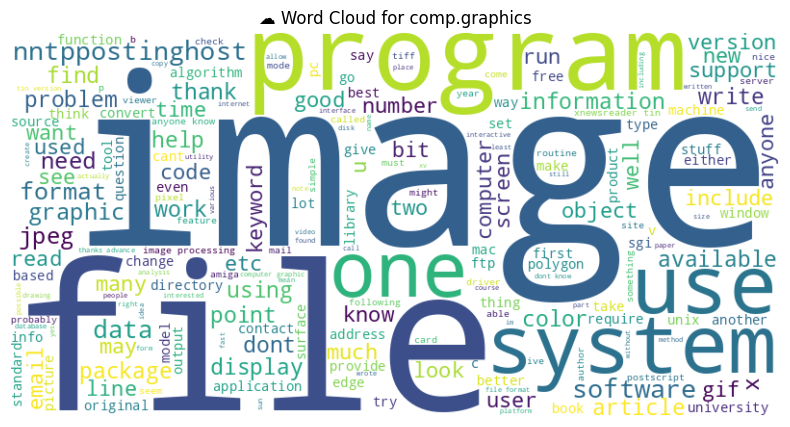

In [ ]:
def generate_wordcloud(category):

    texts = " ".join(df_train[df_train["category"] == category]["text"])
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(texts)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"☁️ Word Cloud for {category}")
    plt.show()

# Generate word cloud for a specific category (change category name)
generate_wordcloud("comp.graphics")

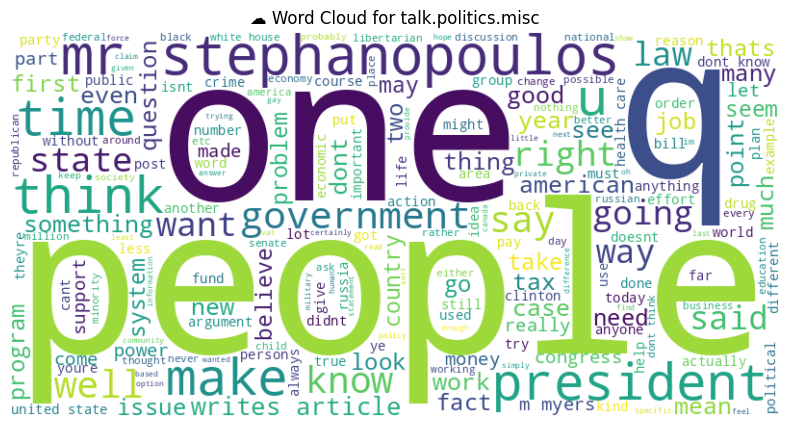

In [ ]:
def generate_wordcloud(category):

    texts = " ".join(df_train[df_train["category"] == category]["text"])
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(texts)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"☁️ Word Cloud for {category}")
    plt.show()

# Generate word cloud for a specific category (change category name)
generate_wordcloud("talk.politics.misc")

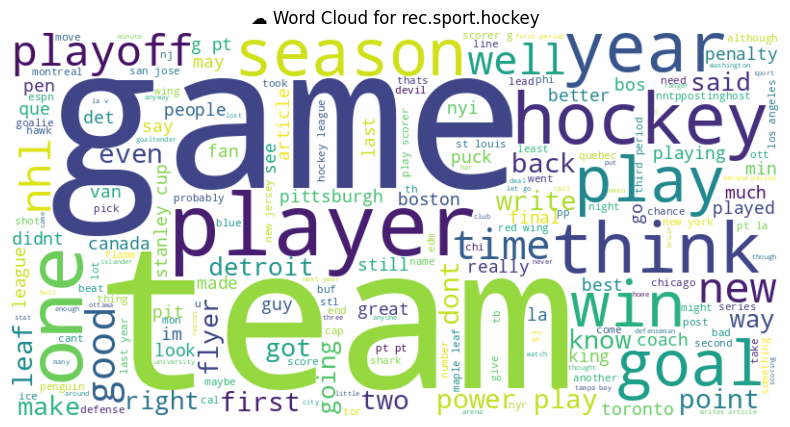

In [ ]:
def generate_wordcloud(category):

    texts = " ".join(df_train[df_train["category"] == category]["text"])
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(texts)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"☁️ Word Cloud for {category}")
    plt.show()

# Generate word cloud for a specific category (change category name)
generate_wordcloud("rec.sport.hockey")

In [ ]:
#Calculate Word Frequencies

word_freq = Counter(all_words).most_common(20)

# Convert to DataFrame
word_freq_df = pd.DataFrame(word_freq, columns=["Word", "Frequency"])

# Plot using Plotly
fig = px.bar(word_freq_df, x="Word", y="Frequency", title="Top 20 Most Common Words")
fig.show()

Vocabulary Overlap Between Technology and Sports Categories

In [ ]:
import spacy
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import re

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def clean_text(text):
    """Additional text cleaning before processing"""
    text = re.sub(r'\S+@\S+', '', text)  # Remove emails
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'\b\d+\b', '', text)  # Remove standalone numbers
    return text

def advanced_processing(text_series, min_tfidf=0.2, max_df=0.2):
    """Enhanced processing pipeline"""
    processed_texts = []

    for doc in nlp.pipe(text_series.apply(clean_text), batch_size=1000):
        lemmas = []
        for token in doc:
            # Strict filtering criteria
            if (token.is_alpha and not token.is_stop and len(token.lemma_) > 3
                and not token.like_email and not token.like_url
                and not token.is_digit and not token.is_punct
                and not token.lemma_.lower() in {'say', 'make', 'use', 'go'}  # Common verb filter
                and not any(ent for ent in doc.ents if ent.text == token.text)):

                lemma = token.lemma_.lower().strip()
                if len(lemma) > 3:  # Minimum length requirement
                    lemmas.append(lemma)

        processed_texts.append(" ".join(lemmas))

    # TF-IDF with stricter parameters
    vectorizer = TfidfVectorizer(
        max_df=max_df,
        min_df=10,
        max_features=2000,
        stop_words='english',
        ngram_range=(1, 1)
    )

    X = vectorizer.fit_transform(processed_texts)

    # Get important words
    feature_names = vectorizer.get_feature_names_out()
    tfidf_scores = X.max(axis=0).toarray().flatten()
    vocab = {word for word, score in zip(feature_names, tfidf_scores)
             if score > min_tfidf and not any(c.isdigit() for c in word)}

    return vocab
# Assuming df_train is your DataFrame with 'text' and 'category' columns
tech_texts = df_train[df_train["category"] == "comp.graphics"]["text"]  # Replace "comp.graphics" with your actual technology category
sports_texts = df_train[df_train["category"] == "rec.sport.hockey"]["text"]  # Replace "rec.sport.hockey" with your actual sports category
# Apply processing
tech_vocab = advanced_processing(tech_texts, min_tfidf=0.25, max_df=0.15)
sports_vocab = advanced_processing(sports_texts, min_tfidf=0.25, max_df=0.15)

# Filter results
common_words = tech_vocab & sports_vocab
tech_unique = sorted(tech_vocab - common_words)
sports_unique = sorted(sports_vocab - common_words)

print(f"Significant overlapping words ({len(common_words)}):")
print(sorted(common_words)[:20])

print(f"\nTechnology unique words ({len(tech_unique)}):")
print(tech_unique[:20])

print(f"\nSports unique words ({len(sports_unique)}):")
print(sports_unique[:20])

Significant overlapping words (182):
['actually', 'address', 'advance', 'advantage', 'allow', 'answer', 'anybody', 'appear', 'appreciate', 'april', 'area', 'assume', 'base', 'board', 'brian', 'canada', 'cause', 'center', 'centre', 'certainly']

Technology unique words (395):
['able', 'accept', 'access', 'adobe', 'agree', 'algorithm', 'amiga', 'analysis', 'andor', 'animation', 'anonymous', 'apple', 'application', 'apply', 'archie', 'archive', 'aspect', 'australia', 'author', 'available']

Sports unique words (477):
['absolutely', 'accord', 'account', 'acquire', 'action', 'adam', 'adirondack', 'affiliate', 'alan', 'allstar', 'america', 'american', 'anderson', 'andersson', 'andrew', 'andrewidacomhpcom', 'andy', 'angeles', 'announce', 'announcer']


In [ ]:
# Test case for lemmatization
test_phrases = ["rendering images", "goaltender saves", "algorithms processing"]
for phrase in test_phrases:
    doc = nlp(phrase)
    print(f"Original: {phrase} → Lemmas: {[token.lemma_ for token in doc]}")

Original: rendering images → Lemmas: ['render', 'image']
Original: goaltender saves → Lemmas: ['goaltender', 'save']
Original: algorithms processing → Lemmas: ['algorithm', 'processing']


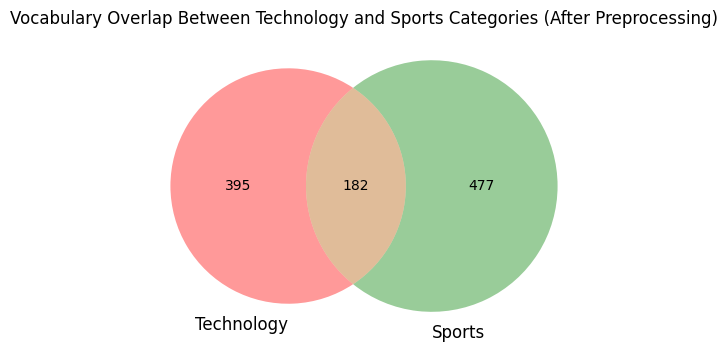

In [ ]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

# Compute word sets

technology_words = " ".join(df_train[df_train["category"] == "comp.graphics"]["text"]).split()  # Example category: "comp.graphics"
sports_words = " ".join(df_train[df_train["category"] == "rec.sport.hockey"]["text"]).split()

# Create Venn diagram
plt.figure(figsize=(6,4))
venn = venn2([tech_vocab, sports_vocab], ('Technology', 'Sports'))

# Update text labels to match correct word counts
# Replacing 'common_vocab' with 'common_words'
venn.get_label_by_id('10').set_text(len(tech_vocab - common_words))  # Only tech
venn.get_label_by_id('01').set_text(len(sports_vocab - common_words))  # Only sports
venn.get_label_by_id('11').set_text(len(common_words))  # Overlapping words

plt.title("Vocabulary Overlap Between Technology and Sports Categories (After Preprocessing)")
plt.show()

## **Feature Extraction**

### **1. Convert Text into TF-IDF Features**

In [ ]:
# Convert text into TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
X_tfidf = tfidf_vectorizer.fit_transform(df_train["text"])

# Extract top TF-IDF words
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = np.asarray(X_tfidf.mean(axis=0)).flatten()

# Create DataFrame for top TF-IDF words
tfidf_df = pd.DataFrame({'Word': feature_names, 'TF-IDF Score': tfidf_scores})
tfidf_df = tfidf_df.sort_values(by="TF-IDF Score", ascending=False).head(20)

# Plot TF-IDF Scores
fig = px.bar(tfidf_df, x="Word", y="TF-IDF Score", title=" Top 20 Most Important Words (TF-IDF)")
fig.show()

### **2. Extract Bigrams Using CountVectorizer**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Extract Bigrams
vectorizer = CountVectorizer(ngram_range=(2,2), stop_words="english")
X_vec = vectorizer.fit_transform(df_train["text"])

# Get top bigrams
bigram_freq = pd.DataFrame(X_vec.toarray(), columns=vectorizer.get_feature_names_out()).sum().sort_values(ascending=False).head(10)

# Plot bigram frequencies
fig = px.bar(x=bigram_freq.values, y=bigram_freq.index, title="Top 10 Most Common Bigrams", labels={"x": "Frequency", "y": "Bigrams"})
fig.show()

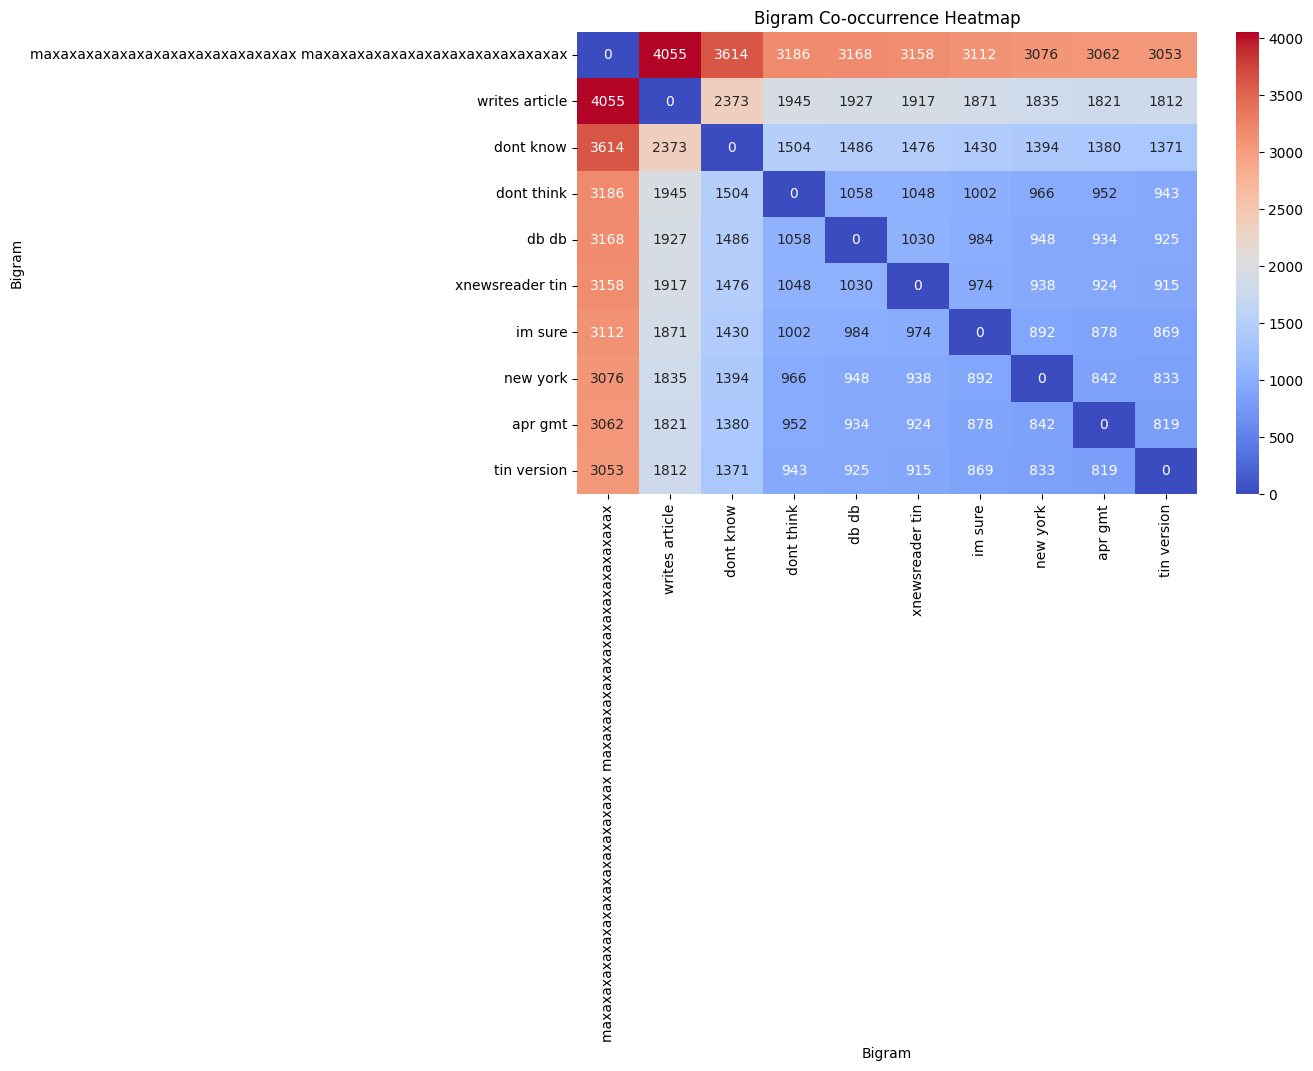

In [ ]:
import seaborn as sns

# Convert bigrams to matrix format
bigram_matrix = np.zeros((10, 10))
bigram_labels = bigram_freq.index[:10]

for i, bigram in enumerate(bigram_labels):
    for j, bigram2 in enumerate(bigram_labels):
        if bigram == bigram2:
            continue
        bigram_matrix[i, j] = bigram_freq.get(bigram, 0) + bigram_freq.get(bigram2, 0)

# Plot Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(bigram_matrix, xticklabels=bigram_labels, yticklabels=bigram_labels, cmap="coolwarm", annot=True, fmt=".0f")
plt.title("Bigram Co-occurrence Heatmap")
plt.xlabel("Bigram")
plt.ylabel("Bigram")
plt.show()

### **3. LDA Model Training (LatentDirichletAllocation)**

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

# Apply LDA for topic modeling
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X_tfidf)

# Display top words for each topic
num_words = 10
feature_names = tfidf_vectorizer.get_feature_names_out()

topic_data = []
for topic_idx, topic in enumerate(lda.components_):
    topic_data.append({
        "Topic": f"Topic {topic_idx + 1}",
        "Top Words": ", ".join([feature_names[i] for i in topic.argsort()[:-num_words - 1:-1]])
    })

topic_df = pd.DataFrame(topic_data)

# Interactive Table of Topics
fig = px.bar(topic_df, x="Topic", y="Top Words", title=" Interactive Topic Modeling (LDA)")
fig.show()

### **4. Optimized TF/IDF Vectorization and Handlling Missing Value**

In [ ]:
#. Optimize TF-IDF Vectorization
vectorizer = TfidfVectorizer(
    max_df=0.90,  # Reduce very common words
    min_df=3,  # Capture slightly rarer words
    ngram_range=(1, 3),  # Unigrams, Bigrams, Trigrams
    max_features=50000,  # Use larger vocabulary
    stop_words="english",
    sublinear_tf=True
)

#. Handle Missing Data
df_train["text"] = df_train["text"].fillna("")

### **5. Transform Train and Test Data**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# Transform train and test data
X_train_tfidf = vectorizer.fit_transform(df_train["text"])
X_test_tfidf = vectorizer.transform(df_test["text"])

# Convert labels to numerical format
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_train["category"])
y_test = label_encoder.transform(df_test["category"])

## **Splitting the Dataset**

In [ ]:
# Split train data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_tfidf, y_train, test_size=0.1, random_state=42)

## **Model Implementation (Machine Learning)**

### **1. Support Vector Machine**

In [ ]:
from sklearn.svm import SVC

# Train an SVM classifier
svm_model = SVC(kernel="linear")
svm_model.fit(X_train, y_train)

SVC(kernel='linear')

In [ ]:
# Predict on validation data
y_val_pred = svm_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Predict on test set
y_test_pred = svm_model.predict(X_test_tfidf)

Validation Accuracy: 0.8905


In [ ]:
# Test Accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.8008


In [ ]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))


Classification Report:
                          precision    recall  f1-score   support

             alt.atheism       0.80      0.69      0.74       319
           comp.graphics       0.61      0.77      0.68       389
 comp.os.ms-windows.misc       0.75      0.68      0.71       394
comp.sys.ibm.pc.hardware       0.69      0.75      0.72       392
   comp.sys.mac.hardware       0.81      0.82      0.82       385
          comp.windows.x       0.86      0.75      0.80       395
            misc.forsale       0.77      0.84      0.80       390
               rec.autos       0.85      0.83      0.84       396
         rec.motorcycles       0.95      0.90      0.92       398
      rec.sport.baseball       0.91      0.92      0.91       397
        rec.sport.hockey       0.96      0.91      0.93       399
               sci.crypt       0.93      0.85      0.89       396
         sci.electronics       0.65      0.71      0.68       393
                 sci.med       0.87      0.83      

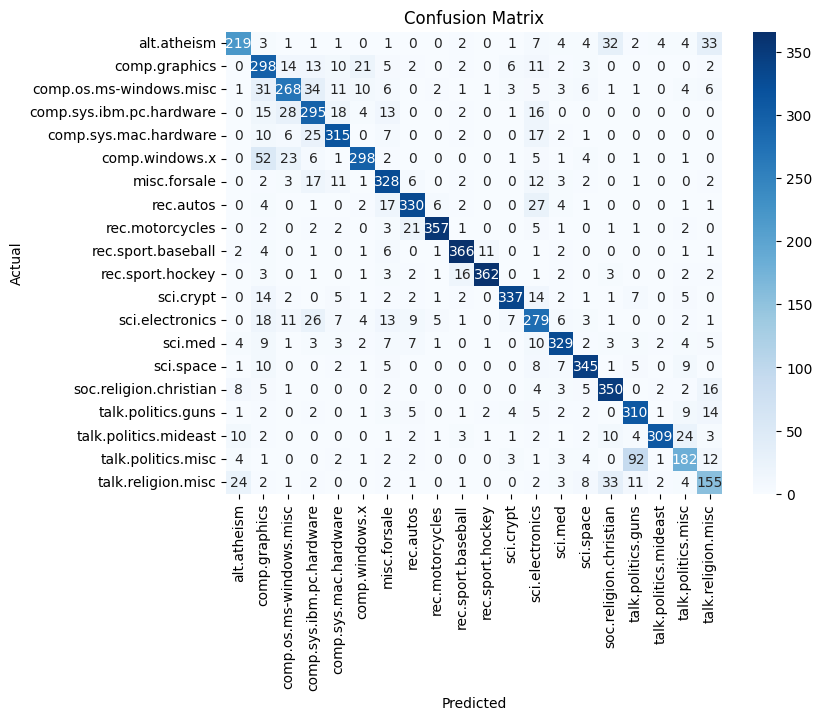

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### **2. Multinomial Naive Bayes**

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Train a Naïve Bayes classifier
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

MultinomialNB()

In [ ]:
# Predict on validation data
y_val_pred = nb_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Predict on test set
y_test_pred = nb_model.predict(X_test_tfidf)

Validation Accuracy: 0.8560


In [ ]:
# Test Accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.7873


In [ ]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))


Classification Report:
                          precision    recall  f1-score   support

             alt.atheism       0.84      0.56      0.68       319
           comp.graphics       0.64      0.74      0.69       389
 comp.os.ms-windows.misc       0.80      0.60      0.68       394
comp.sys.ibm.pc.hardware       0.62      0.78      0.69       392
   comp.sys.mac.hardware       0.79      0.81      0.80       385
          comp.windows.x       0.81      0.80      0.81       395
            misc.forsale       0.87      0.77      0.82       390
               rec.autos       0.85      0.89      0.87       396
         rec.motorcycles       0.94      0.91      0.92       398
      rec.sport.baseball       0.94      0.92      0.93       397
        rec.sport.hockey       0.94      0.95      0.94       399
               sci.crypt       0.78      0.91      0.84       396
         sci.electronics       0.74      0.62      0.68       393
                 sci.med       0.87      0.81      

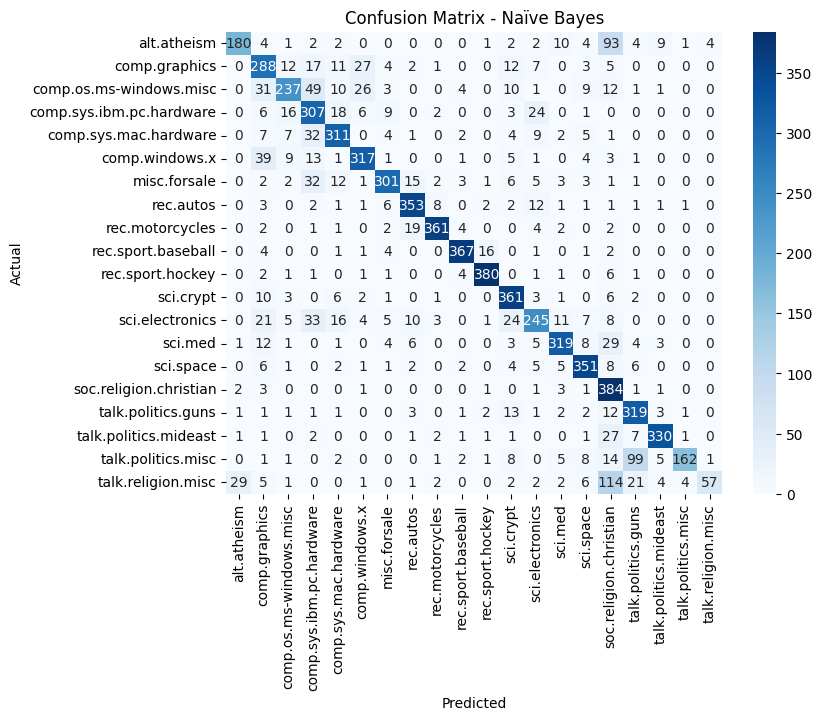

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Naïve Bayes")
plt.show()

### **3. Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  # 100 trees
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Predict on validation data
y_val_pred = rf_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Predict on test set
y_test_pred = rf_model.predict(X_test_tfidf)

Validation Accuracy: 0.8065


In [ ]:
# Test Accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.7284


In [ ]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))


Classification Report:
                          precision    recall  f1-score   support

             alt.atheism       0.66      0.58      0.62       319
           comp.graphics       0.52      0.69      0.59       389
 comp.os.ms-windows.misc       0.63      0.69      0.66       394
comp.sys.ibm.pc.hardware       0.60      0.62      0.61       392
   comp.sys.mac.hardware       0.74      0.72      0.73       385
          comp.windows.x       0.82      0.65      0.72       395
            misc.forsale       0.63      0.83      0.72       390
               rec.autos       0.78      0.78      0.78       396
         rec.motorcycles       0.90      0.89      0.90       398
      rec.sport.baseball       0.81      0.89      0.84       397
        rec.sport.hockey       0.88      0.88      0.88       399
               sci.crypt       0.86      0.83      0.85       396
         sci.electronics       0.62      0.51      0.56       393
                 sci.med       0.78      0.70      

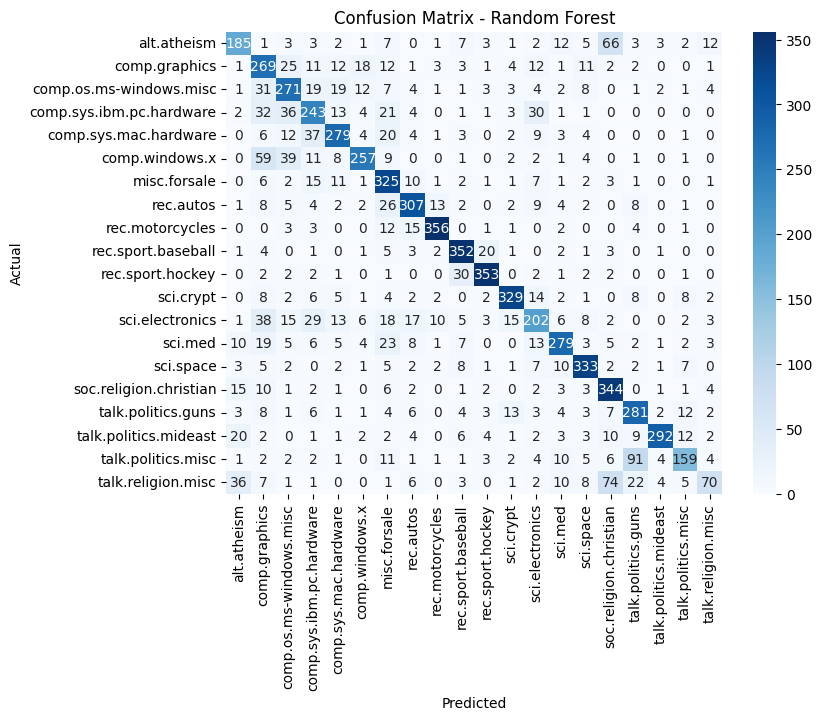

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

### **4. XGBoost**

In [ ]:
# Install XGBoost if not already installed
!pip install xgboost

In [ ]:
from xgboost import XGBClassifier #Takes long time to execute(max 15mins)

# Train an XGBoost classifier
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
# Predict on validation data
y_val_pred = xgb_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Predict on test set
y_test_pred = xgb_model.predict(X_test_tfidf)

Validation Accuracy: 0.7809


In [ ]:
# Test Accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.7069


In [ ]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))


Classification Report:
                          precision    recall  f1-score   support

             alt.atheism       0.68      0.58      0.63       319
           comp.graphics       0.55      0.65      0.60       389
 comp.os.ms-windows.misc       0.60      0.61      0.61       394
comp.sys.ibm.pc.hardware       0.60      0.71      0.65       392
   comp.sys.mac.hardware       0.73      0.73      0.73       385
          comp.windows.x       0.75      0.60      0.67       395
            misc.forsale       0.70      0.77      0.73       390
               rec.autos       0.78      0.73      0.76       396
         rec.motorcycles       0.90      0.85      0.87       398
      rec.sport.baseball       0.79      0.84      0.82       397
        rec.sport.hockey       0.88      0.85      0.86       399
               sci.crypt       0.87      0.76      0.81       396
         sci.electronics       0.43      0.55      0.48       393
                 sci.med       0.77      0.72      

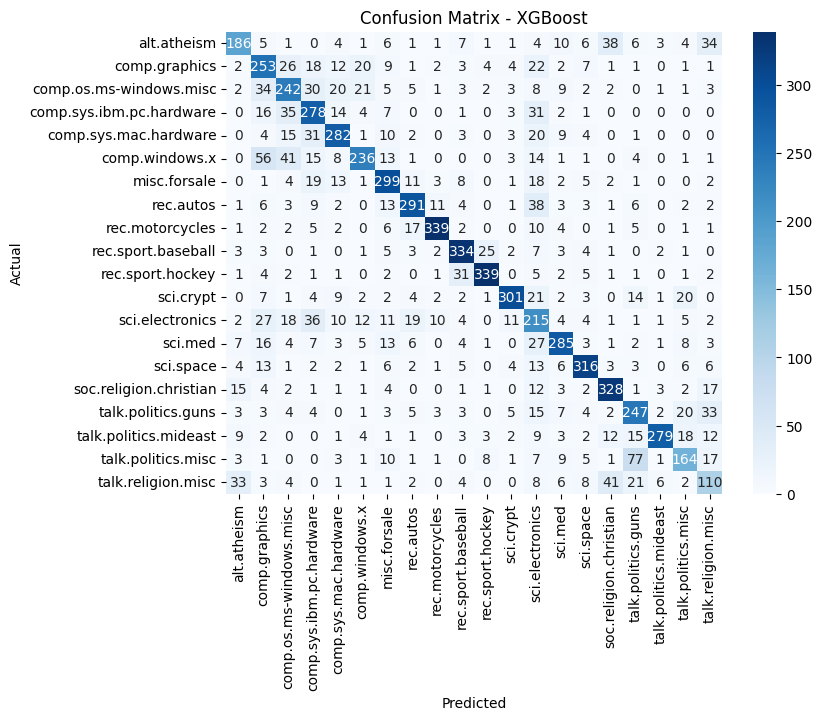

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()

## **Hyperparameter Tuning**

### **1. SVM - Grid Search (Linear & RBF Kernels)**

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']  # Only used for RBF
}

svm_grid = GridSearchCV(SVC(), svm_params, cv=5, scoring='accuracy', n_jobs=-1)
svm_grid.fit(X_train, y_train)

print("🔹 Best SVM Parameters:", svm_grid.best_params_)
print("🔹 Best SVM Score:", svm_grid.best_score_)

best_svm = svm_grid.best_estimator_

🔹 Best SVM Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
🔹 Best SVM Score: 0.8888236099738338


### **2. Multinomial Naive Bayes - Grid Search**

In [ ]:
from sklearn.naive_bayes import MultinomialNB

nb_params = {
    'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]
}

nb_grid = GridSearchCV(MultinomialNB(), nb_params, cv=5, scoring='accuracy', n_jobs=-1)
nb_grid.fit(X_train, y_train)

print("🔹 Best Naive Bayes Parameters:", nb_grid.best_params_)
print("🔹 Best Naive Bayes Score:", nb_grid.best_score_)

best_nb = nb_grid.best_estimator_

🔹 Best Naive Bayes Parameters: {'alpha': 0.1}
🔹 Best Naive Bayes Score: 0.8822433313754481


### **3. Random Forest - Randomized Search**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 20, 50],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

rf_random = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    rf_params,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)
rf_random.fit(X_train, y_train)

print("🔹 Best RF Parameters:", rf_random.best_params_)
print("🔹 Best RF Score:", rf_random.best_score_)

best_rf = rf_random.best_estimator_

🔹 Best RF Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}
🔹 Best RF Score: 0.831271140096814


### **4. XGBoost - Randomized Search**

****  Executing this for 5h 6m 56s and then forced to stop the execution   *****

In [ ]:
from xgboost import XGBClassifier

xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_random = RandomizedSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    xgb_params,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)
xgb_random.fit(X_train, y_train)

print("🔹 Best XGBoost Parameters:", xgb_random.best_params_)
print("🔹 Best XGBoost Score:", xgb_random.best_score_)

best_xgb = xgb_random.best_estimator_


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



## **Ensemble Learning (Stacking)**

**Combining LogisticRegression and SVM into a stacking ensemble**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC  # SVM Model
from sklearn.ensemble import StackingClassifier  # Ensemble
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load Data
train_df = pd.read_csv("/content/drive/MyDrive/processed_train.csv")

# Check column names
print(train_df.columns)

#. Optimize TF-IDF Vectorization
vectorizer = TfidfVectorizer(
    max_df=0.90,  # Reduce very common words
    min_df=3,  # Capture slightly rarer words
    ngram_range=(1, 3),  # Unigrams, Bigrams, Trigrams
    max_features=50000,  # Use larger vocabulary
    stop_words="english",
    sublinear_tf=True
)

#. Handle Missing Data
train_df["text"] = train_df["text"].fillna("")

#. Split Dataset (Stratified)
X_train, X_test, y_train, y_test = train_test_split(
    train_df["text"], train_df["category"], test_size=0.2, random_state=42, stratify=train_df["category"]
)

#. Apply TF-IDF Transformation
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

#. Encode Labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

#. Feature Selection (Keep Only Top Features)
selector = SelectKBest(chi2, k=min(10000, X_train_tfidf.shape[1]))  # Keep top 10,000 features
X_train_tfidf = selector.fit_transform(X_train_tfidf, y_train)
X_test_tfidf = selector.transform(X_test_tfidf)

#. Train an Improved Classifier
logistic = LogisticRegression(C=2.0, max_iter=2000, solver="liblinear", class_weight="balanced")
svm = SVC(C=2.0, kernel="linear", probability=True)  # SVM for better text classification

#. Ensemble Model (Stacking)
model = StackingClassifier(
    estimators=[("lr", logistic), ("svm", svm)], final_estimator=LogisticRegression()
)

model.fit(X_train_tfidf, y_train)

#. Evaluate Model
y_pred = model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

#. Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### **Optimized Ensemble Model (Stacking)**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load Data
train_df = pd.read_csv("/content/drive/MyDrive/processed_train.csv")

# Handle Missing Data
train_df["text"] = train_df["text"].fillna("")

# TF-IDF Vectorization (Optimized)
vectorizer = TfidfVectorizer(
    max_df=0.85,
    min_df=2,
    ngram_range=(1, 3),
    max_features=75000,
    stop_words="english",
    sublinear_tf=True,
    norm='l2'  # Normalize vectors
)

# Split Dataset (Stratified)
X_train, X_test, y_train, y_test = train_test_split(
    train_df["text"], train_df["category"], test_size=0.2, random_state=42, stratify=train_df["category"]
)

# Apply TF-IDF Transformation
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Encode Labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Feature Selection (Top 15,000 Features)
selector = SelectKBest(chi2, k=min(15000, X_train_tfidf.shape[1]))
X_train_tfidf = selector.fit_transform(X_train_tfidf, y_train)
X_test_tfidf = selector.transform(X_test_tfidf)

# Improved Classifiers
logistic = LogisticRegression(C=5.0, max_iter=5000, solver="liblinear", class_weight="balanced")
svm = SVC(C=5.0, kernel="linear", probability=True, class_weight="balanced")
extra_trees = ExtraTreesClassifier(n_estimators=100, random_state=42)

# Optimized Ensemble Model (Stacking)
model = StackingClassifier(
    estimators=[("lr", logistic), ("svm", svm), ("et", extra_trees)],
    final_estimator=RandomForestClassifier(n_estimators=200, random_state=42)
)

# Train Model
model.fit(X_train_tfidf, y_train)

# Evaluate Model
y_pred = model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


## **Model Implementation (Deep Learning)**

### **Preprocessing for CNN and RCNN**

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np

# Example setup
vocab_size = 20000
max_len = 300

# Tokenization
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(df_train['text'])
X_train_seq = tokenizer.texts_to_sequences(df_train['text'])
X_test_seq = tokenizer.texts_to_sequences(df_test['text'])

# Padding
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# Label Encoding
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(df_train['category'])
y_test_enc = label_encoder.transform(df_test['category'])
num_classes = len(label_encoder.classes_)

# Convert to categorical
from tensorflow.keras.utils import to_categorical
y_train_cat = to_categorical(y_train_enc, num_classes)
y_test_cat = to_categorical(y_test_enc, num_classes)


### **1. CNN**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

def build_cnn_model():
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len),
        Conv1D(128, kernel_size=5, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

cnn_model = build_cnn_model()
cnn_history = cnn_model.fit(X_train_pad, y_train_cat, epochs=15, batch_size=128, validation_split=0.1)

cnn_preds = cnn_model.predict(X_test_pad).argmax(axis=1)
print("\n CNN Test Accuracy:", accuracy_score(y_test_enc, cnn_preds))
print(classification_report(y_test_enc, cnn_preds, target_names=label_encoder.classes_))

### **2. RCNN**

In [ ]:
from tensorflow.keras.layers import LSTM, Bidirectional, TimeDistributed

def build_rcnn_model():
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len),
        Conv1D(64, kernel_size=3, padding='same', activation='relu'),
        Bidirectional(LSTM(64, return_sequences=True)),
        GlobalMaxPooling1D(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

rcnn_model = build_rcnn_model()
rcnn_history = rcnn_model.fit(X_train_pad, y_train_cat, epochs=15, batch_size=128, validation_split=0.1)

rcnn_preds = rcnn_model.predict(X_test_pad).argmax(axis=1)
print("\n RCNN Test Accuracy:", accuracy_score(y_test_enc, rcnn_preds))
print(classification_report(y_test_enc, rcnn_preds, target_names=label_encoder.classes_))

### **Evaluation on Test Set**

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# CNN
cnn_preds = cnn_model.predict(X_test_pad).argmax(axis=1)
print("CNN Test Accuracy:", accuracy_score(y_test_enc, cnn_preds))

# RCNN
rcnn_preds = rcnn_model.predict(X_test_pad).argmax(axis=1)
print("RCNN Test Accuracy:", accuracy_score(y_test_enc, rcnn_preds))

### **Training & Validation Curve Plotting**

In [ ]:
import matplotlib.pyplot as plt

def plot_training_curves(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Train Acc')
    plt.plot(epochs, val_acc, 'r--', label='Val Acc')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Train Loss')
    plt.plot(epochs, val_loss, 'r--', label='Val Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
plot_training_curves(cnn_history, "CNN")
plot_training_curves(rcnn_history, "RCNN")

### **Comparison of Model Accuracy and Model Loss**

In [ ]:
import matplotlib.pyplot as plt

def plot_multiple_training_curves(histories, metric='accuracy', title='Accuracy Comparison'):
    """
    Plot training & validation curves for multiple models.

    Parameters:
    - histories: dict with {label: history_object}
    - metric: 'accuracy' or 'loss'
    """
    plt.figure(figsize=(14, 6))

    # Plot training and validation for each model
    for name, history in histories.items():
        plt.plot(history.history[metric], label=f'{name} - Train')
        plt.plot(history.history['val_' + metric], label=f'{name} - Val')

    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# Dictionary of histories
all_histories = {
    'CNN': cnn_history,
    'RCNN': rcnn_history
}

# Plot Accuracy Comparison
plot_multiple_training_curves(all_histories, metric='accuracy', title='Model Accuracy Comparison')

# Plot Loss Comparison
plot_multiple_training_curves(all_histories, metric='loss', title='Model Loss Comparison')